In [49]:
import numpy as np
import sympy as sym  ## Sympy es una biblioteca de Python para realizar cálculos simbólicos, en lugar de numéricos.
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import norm 

In [50]:
"""
opcion_europea_bs
Def
    Calculador del precio de una opcion Europea con el modelo de Black Scholes
Inputs
    - tipo : string - Tipo de contrato entre ["CALL","PUT"]
    - S : float - Spot price del activo
    - K : float - Strike price del contrato
    - T : float - Tiempo hasta la expiracion (en años)
    - r : float - Tasa 'libre de riesgo' (anualizada)
    - sigma : float - Volatilidad implicita (anualizada)
    - div : float - Tasa de dividendos continuos (anualizada)
Outputs
    - precio_BS: float - Precio del contrato
"""

def opcion_europea_bs(tipo, S, K, T, r, sigma, div):
    #Defino los ds
    d1 = (np.log(S / K) + (r - div + 0.5 * sigma * sigma) * T) / sigma / np.sqrt(T)
    d2 = (np.log(S / K) + (r - div - 0.5 * sigma * sigma) * T) / sigma / np.sqrt(T)

    if (tipo == "C"):
        precio_BS = np.exp(-div*T) *S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif (tipo == "P"):
        precio_BS = K * np.exp(-r * T) * norm.cdf(-d2) - np.exp(-div*T) * S * norm.cdf(-d1)
    return precio_BS

## Ejemplo: Replicando un CPM con bonos, futuros y opciones

 Consideremos un mercado de producto constante con estado 
    $$(t,R_a,R_b)=(1,10,200)$$
El precio de $\beta$ es unidades de $\alpha$ es $m_p ^1 = \frac{R_\beta}{R_{\alpha}}$.
El valor inicial del pool (en unidades de $\beta$) es 
$$P_V ^1 = (m_p ^1 R_{\alpha}^{1}+R_{\beta}^{1})=0.005*200 + 10 = 20 $$  

El portfolio replicador es:


Valor nominal del bono: $f(m^{0})= 2\sqrt{km^{0}}= 2\sqrt{2000*0.05}=20$

Valor nocional de futuros $m^0$: $f'(m^0)=\sqrt{\frac{k}{m^{0}}}= \sqrt{\frac{2000}{0.05}}=200$

Valor nocional de las opciones con strike $K$:  $f''(K)=-\frac{1}{2}\sqrt{\frac{k}{K^3}} dK = -\frac{0.0125}{2}\sqrt{\frac{2000}{K^3}} dK$


Si por ejemplo tenemos un numero discreto de strikes $K=(0.125, 0.025, . . . , 0.1)$ el payoff al vencimiento nos queda 

$$
    P_V^{T}=f(m^0)+f'(m^0)(m^T-m^0)+
     \sum_{K\leq m_p ^{0}}f''(K)P(K)\Delta K +\sum_{K>m_p ^0} f''(K)C(K)\Delta K.
$$


In [54]:
def face_value_bond (x, k):
    return 2*np.sqrt(k*x)
def notional_future (x, k): 
    return np.sqrt(k/x)  
def notional_option (x, delta_x, k):
    return -(1/2)*np.sqrt(k/(x**3))*(delta_x)


def replicator_with_option_discr_bs(m_T, m_0, K, k):
    # Parámetros para las opciones
    T = 1
    r = 0.1
    div = 0
    sigma = 0.2
    bond = face_value_bond(m_0, k)
    futures = notional_future(m_0,k)*(m_T-m_0)
    sum_calls = 0
    sum_puts = 0
    for i in range(1, len(K)):
        if K[i] > m_0: 
            sum_calls = sum_calls + notional_option(K[i],K[i]-K[i-1],k)*opcion_europea_bs("C", m_T, K[i], T, r , sigma, div)
        else:
            sum_puts = sum_puts + notional_option(K[i],K[i]-K[i-1],k)*opcion_europea_bs("P", m_T, K[i], T, r , sigma, div)
    return bond + futures + sum_calls + sum_puts           

C:\Users\seque\AppData\Local\Temp/ipykernel_12956/1681954382.py:19: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r - div + 0.5 * sigma * sigma) * T) / sigma / np.sqrt(T)
C:\Users\seque\AppData\Local\Temp/ipykernel_12956/1681954382.py:20: RuntimeWarning: divide by zero encountered in log
  d2 = (np.log(S / K) + (r - div - 0.5 * sigma * sigma) * T) / sigma / np.sqrt(T)


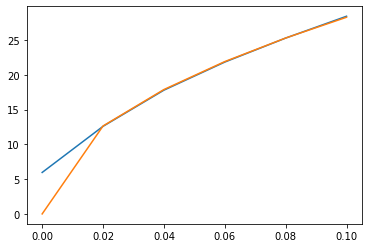

In [55]:
S = np.linspace(0, 0.1, 6) # rango a graficar 
m_0 = 0.05
k= 2000
# strikes
K = np.linspace(0.0125,0.1,8)

replicator_discr_bs = replicator_with_option_discr_bs(S,m_0,K,k)
#Grafico el Strangle
plt.plot(S, replicator_discr_bs)
plt.plot(S, 2*np.sqrt(k*S))
plt.show()

### Acá intenté usar sympy pero no corre

In [53]:
def replicador_with_option_CPM_bs (m_T, m_0, k, eps, cot_sup):
    T = 1
    r = 0.1
    div = 0
    sigma = 0.2
    bond = face_value_bond(m_0, k)
    futures = notional_future(m_0,k)*(m_T - m_0)
    x = sym.Symbol('x', real=True)
    f_call = -(1/2)*sym.sqrt(k/(x**3))* opcion_europea_bs("C", m_T, x, T, r , sigma, div)
    f_put = -(1/2)*sym.sqrt(k/(x**3))* opcion_europea_bs("P", m_T, x, T, r, sigma, div )
    int_calls =sym.integrate(f_call,(x, m_0, cot_sup))  
    int_puts = sym.integrate(f_put,(x, eps, m_0))
    return bond + futures + int_calls + int_puts
   
replicador_with_option_CPM_bs(0.1, 0.05, 2000,0.001,1)   

TypeError: loop of ufunc does not support argument 0 of type Mul which has no callable log method

In [23]:
S = np.linspace(0, 0.1, 20) # rango a graficar 
m_0 = 0.05
k = 2000
eps =0.0001
cot_sup = 0.1
replicador_bs = replicador_with_option_CPM_bs(S, m_0, k, eps, cot_sup)

#Grafico el Strangle
plt.plot(S, replicador_bs)
plt.plot(S, 2*np.sqrt(k*S))
plt.show()

TypeError: only size-1 arrays can be converted to Python scalars